In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from datetime import datetime

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import classification_report, roc_auc_score

In [6]:
modelos = [
    {
        "nombre": "Naive Bayes",
        "modelo": MultinomialNB(),
        "param_grid": {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            "fit_prior": [True, False],
        },
    },
    {
        "nombre": "Arbol Clasificacion",
        "modelo": DecisionTreeClassifier(),
        "param_grid": {
            "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
            "max_leaf_nodes": [1, 2, 3, 4, 5],
            "criterion": ["gini", "entropy"],
        },
    },
    {
        "nombre": "Random Forest",
        "modelo": RandomForestClassifier(),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "n_estimators": [500, 600, 700, 800, 900, 1000],
            "max_features": ["sqrt", "log2"],
            "max_leaf_nodes": [None, 10, 50, 100, 500],
            "min_samples_split": [2, 5, 10, 20],
        },
    },
    {
        "nombre": "Gradient Bossting",
        "modelo": GradientBoostingClassifier(),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "learning_rate": [0.001, 0.01, 0.1, 1],
            "max_leaf_nodes": [None, 10, 50, 100, 500],
            "min_samples_split": [2, 5, 10, 20],
        },
    },
    {
        "nombre": "Ada Boost",
        "modelo": AdaBoostClassifier(),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.5, 1.0],
            "algorithm": ["SAMME", "SAMME.R"],
        },
    },
]

In [53]:
def entrenar_ensamble_de_modelos_gridcv(
    grilla_gridcv_con_modelos, X_train, X_test, y_train, y_test
):
    for model_info in grilla_gridcv_con_modelos:
        print("Training", model_info["nombre"], "...")
        model = model_info["modelo"]
        param_grid = model_info["param_grid"]

        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
        grid_search.fit(X_train, y_train)

        obtener_desempeno_modelo_en_grilla(grid_search, X_test, y_test)

def resumir_resultados_grid_cv(diccionario_resultados):
    df_resultados = pd.DataFrame(diccionario_resultados)
    df_resultados["params_str"] = df_resultados["params"].astype(str)

    return df_resultados


def graficar_resultados_grid_cv(resultado_df):
    sns.lineplot(data=resultado_df, x="params_str", y="mean_test_score", marker="o")
    plt.tick_params(axis="x", labelrotation=90)


def analizar_resultados_grid_cv(diccionario_resultados):
    df_resultados = resumir_resultados_grid_cv(diccionario_resultados)
    graficar_resultados_grid_cv(df_resultados)

    return df_resultados


def obtener_desempeno_modelo_en_grilla(modelo_grilla, X_test, y_test):
    print("--------------Resultados Conjunto de Entrenamiento-----------------")
    print("Los resultados en la busqueda de hiperparametros son:")
    resultados_grilla = analizar_resultados_grid_cv(modelo_grilla.cv_results_)
    plt.show()
    print(f"Los mejores parametros fueron: {modelo_grilla.best_params_}")
    print(f"El mejor desempeno fue: {modelo_grilla.best_score_}")

    print("\n\n--------------Resultados Conjunto de Validacion-----------------")
    yhat = modelo_grilla.predict(X_test)
    print("Los resultados en el conjunto de validacion son:")
    print(classification_report(y_test, yhat))

    print("---------------------------------------------------------------------")

    return resultados_grilla

In [54]:
df = pd.read_csv("RegistroTumores_FALP.csv")

In [55]:
# Deja solo el cancer de mama
mama = df.query("CATEGORIA == 'MAMA'")
mama = mama.drop(columns=["CATEGORIA", "SUBCATEGORIA", "CODIGO_COMUNA"])
# Elimina los que carezcan de un estadio
mama = mama[~mama["ESTADIO"].isna()]
# Binariza la edad
mama["RANGO_ETARIO"] = pd.cut(
    mama["EDAD"],
    [-np.inf, 5, 11, 18, 26, 60, np.inf],
    labels=["Primera Infancia", "Infancia", "Adolescencia", "Juventud", "Adultez", "Vejez"],
)
mama = mama.drop(columns=["EDAD"])

# Rellena los datos patologicos con SO
columnas_a_rellenar_nan = ["CT", "CN", "CM", "PT", "PN", "PM"]
mama[columnas_a_rellenar_nan] = mama[columnas_a_rellenar_nan].fillna("SO")

# Castea las fechas
columnas_fechas = ["FECHA_DIAGNOSTICO", "FECHA_DEFUNCION", "FECHA_INICIO_TTO", "FECHA_FIN_TTO"]
# for fecha in columnas_fechas:
#     mama[fecha] = pd.to_datetime(mama[fecha], yearfirst=True)
#     pd.to_datetime(mama[fecha], yearfirst=True)

# dia_corte = pd.Timestamp(year=2023, month=6, day=8)

# mama["DURACION_TRATAMIENTO"] = mama["FECHA_FIN_TTO"] - mama["FECHA_INICIO_TTO"]
# mama["ESPERA_TRATAMIENTO"] = mama["FECHA_INICIO_TTO"] - mama["FECHA_DIAGNOSTICO"]

mama = mama.drop(columns=columnas_fechas)

# Crea el vector objetivo
reemplazar_estadio = {
    "0": 1,
    "I": 1,
    "II": 2,
    "III": 3,
    "IV": 3,
}

mama["STATUS"] = mama["ESTADIO"].replace(reemplazar_estadio)
mama = mama.drop(columns=["ESTADIO"])
mama = mama.fillna("SO")

In [56]:
final = pd.get_dummies(mama, drop_first=True)
X = final.drop(columns="STATUS")
y = final["STATUS"]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=1)

Training Naive Bayes ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


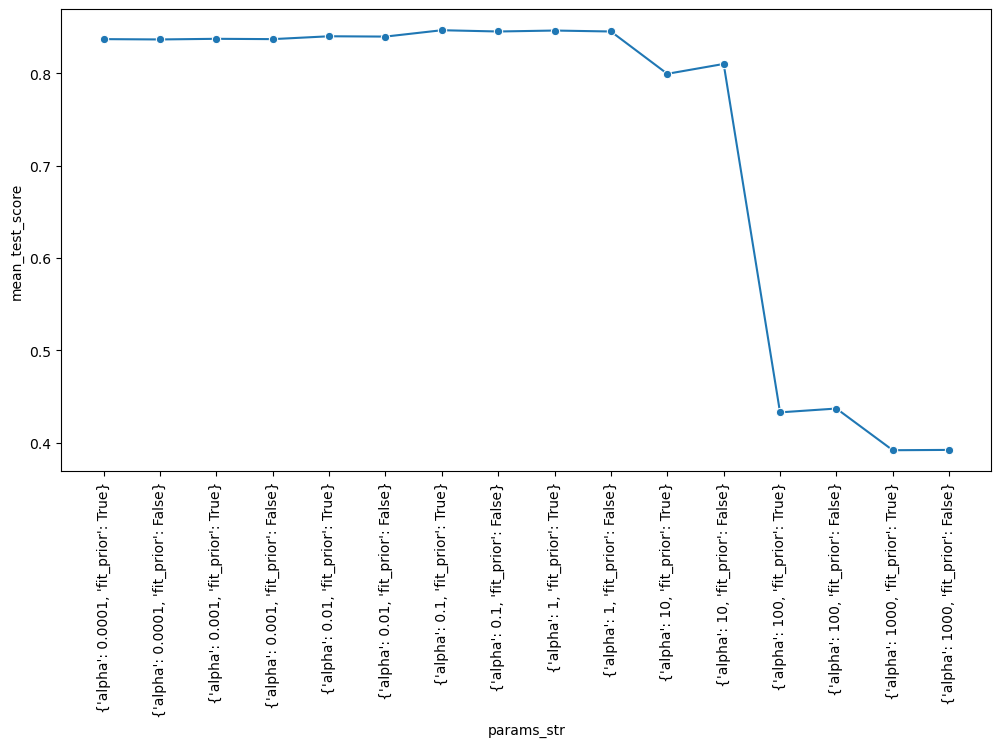

Los mejores parametros fueron: {'alpha': 0.1, 'fit_prior': True}
El mejor desempeno fue: 0.8468965517241379


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.92      0.88      0.90       471
           2       0.83      0.85      0.84       563
           3       0.83      0.85      0.84       414

    accuracy                           0.86      1448
   macro avg       0.86      0.86      0.86      1448
weighted avg       0.86      0.86      0.86      1448

---------------------------------------------------------------------
Training Arbol Clasificacion ...


KeyboardInterrupt: 

In [58]:
entrenar_ensamble_de_modelos_gridcv(modelos, X_train, X_test, y_train, y_test)